# Statistieken SAA

## Introductie

## Data

- `scans_per_inventarisnummer.csv`, afkomstig uit export 'scope' (intern systeem Stadsarchief Amsterdam)
- `aktes_per_inventarisnummer.csv`, afkomstig uit RDF-data Golden Agents met SPARQL-query hieronder
- `htr_per_inventarisnummer.csv`, afkomstig van [Nieuwe series in HTR](https://www.amsterdam.nl/stadsarchief/organisatie/crowdsourcing/crowd-leert-computer-lezen/nieuwe-series-htr/) (website Stadsarchief)
- `notaris_per_inventarisnummer.csv`, afkomstig uit RDF-data Golden Agents uit het [Notarissennetwerk](https://gitlab.com/uvacreate/vondel/notarissennetwerk-rdf) met SPARQL-query hieronder

### Query's

#### Aktes (index)

```sparql
PREFIX roar: <https://data.goldenagents.org/ontology/roar/>
PREFIX dcterms: <http://purl.org/dc/terms/>
SELECT ?permalink ?inventarisnummer ?temporal (COUNT(DISTINCT ?deed) AS ?index_aantal_aktes) (COUNT(DISTINCT ?scan) AS ?index_aantal_scans) WHERE {
    ?permalink a roar:BookIndex ;
             dcterms:identifier ?inventarisnummer ;
             roar:memberOf/roar:subCollectionOf* <https://archief.amsterdam/inventarissen/file/d5b98b7afa50a3af4fba8053b06fb961> .

    OPTIONAL { ?permalink dcterms:temporal ?temporal . }

    OPTIONAL {
        ?permalink roar:indexOf ?physicalBook .

        ?physicalDeed roar:partOf ?physicalBook .

        ?deed roar:indexOf ?physicalDeed ;
              roar:onScan ?scan .
    }

} GROUP BY ?permalink ?inventarisnummer ?temporal
```

#### Notarissen (Notarissennetwerk)

```sparql
PREFIX schema: <http://schema.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?permalink (SAMPLE(?notarissennetwerkp) AS ?notarissennetwerk) (SAMPLE(?notarisn) AS ?notaris) WHERE {
{
      ?permalink schema:author ?notarisid .

    ?notarisid schema:name ?notarisn .

    ?notarissennetwerkp schema:mainEntity ?notarisid .

  }
} GROUP BY ?permalink
```


In [1]:
import pandas as pd
import numpy as np

In [2]:
df_scans = pd.read_csv("scans_per_inventarisnummer.csv")
df_aktes = pd.read_csv("aktes_per_inventarisnummer.csv")
df_htr = pd.read_csv("htr_per_inventarisnummer.csv")
df_notaris = pd.read_csv("notaris_per_inventarisnummer.csv")

In [3]:
df_scans_aktes = pd.merge(
    df_scans,
    df_aktes,
    how="outer",
    on="inventarisnummer",
)
df_scans_aktes_htr = pd.merge(
    df_scans_aktes, df_htr, how="outer", on="inventarisnummer"
)
df_scans_aktes_htr_notaris = pd.merge(
    df_scans_aktes_htr, df_notaris, how="outer", on="permalink"
)

In [4]:
df_scans_aktes_htr_notaris.to_csv("df_scans_aktes_htr_notaris.csv", index=False)

In [5]:
df_scans_aktes_htr_notaris.dropna(subset=["temporal"], inplace=True)

In [6]:
# Replace all the 0's by NaN
df_scans_aktes_htr_notaris.replace(0, np.NaN, inplace=True)


In [7]:
df_scans_aktes_htr_notaris["date_start"] = [
    i.split("/")[0] for i in df_scans_aktes_htr_notaris["temporal"]
]
df_scans_aktes_htr_notaris["date_end"] = [
    i.split("/")[1] for i in df_scans_aktes_htr_notaris["temporal"]
]

# Trick to have dates as periods before 1677-09-22
df_scans_aktes_htr_notaris["date_start"] = df_scans_aktes_htr_notaris[
    "date_start"
].apply(lambda x: pd.Period(x))
df_scans_aktes_htr_notaris["date_end"] = df_scans_aktes_htr_notaris["date_end"].apply(
    lambda x: pd.Period(x)
)

df_scans_aktes_htr_notaris["year_start"] = df_scans_aktes_htr_notaris[
    "date_start"
].apply(lambda x: pd.Period(x).year)
df_scans_aktes_htr_notaris["year_end"] = df_scans_aktes_htr_notaris["date_end"].apply(
    lambda x: pd.Period(x).year
)

# df_scans_aktes_htr_notaris['year_start'] = pd.to_datetime(df_scans_aktes_htr_notaris['year_start'])
# df_scans_aktes_htr_notaris['year_end'] = pd.to_datetime(df_scans_aktes_htr_notaris['year_end'])


In [8]:
df_scans_aktes_htr_notaris

,scopeid,inventarisnummer,aantal_scans,permalink,temporal,index_aantal_aktes,index_aantal_scans,rubriek,htr_notaris,serienummer,htr_titel,htr_aantal_scans,htr_status,notarissennetwerk,notaris,date_start,date_end,year_start,year_end
0,313844.0,1A,41.0,https://archief.amsterdam/inventarissen/file/6...,1578-01-01/1579-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1578-01-01,1579-12-31,1578,1579
1,313845.0,1B,61.0,https://archief.amsterdam/inventarissen/file/7...,1579-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1579-01-01,1580-12-31,1579,1580
2,313846.0,1C,44.0,https://archief.amsterdam/inventarissen/file/6...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,1580
3,313847.0,1D,10.0,https://archief.amsterdam/inventarissen/file/8...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,1580
4,313848.0,1E,33.0,https://archief.amsterdam/inventarissen/file/1...,1581-01-01/1581-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1581-01-01,1581-12-31,1581,1581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32541,NaN,19415,NaN,https://archief.amsterdam/inventarissen/file/1...,1809-01-01/1809-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1809-01-01,1809-12-31,1809,1809
32542,NaN,19418,NaN,https://archief.amsterdam/inventarissen/file/7...,1811-01-01/1811-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1811-01-01,1811-12-31,1811,1811
32543,NaN,19410,NaN,https://archief.amsterdam/inventarissen/file/c...,1804-01-01/1804-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1804-01-01,1804-12-31,1804,1804
32544,NaN,19411,NaN,https://archief.amsterdam/inventarissen/file/c...,1805-01-01/1805-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1805-01-01,1805-12-31,1805,1805


In [9]:
# Per 'group' [= a notary] fill the missing values with the mean of the notary
df_scans_aktes_htr_notaris["schatting_aantal_scans"] = (
    df_scans_aktes_htr_notaris[["aantal_scans", "notarissennetwerk"]]
    .groupby("notarissennetwerk")
    .transform(lambda x: x.fillna(x.mean()))
)

# For the other NaN values, per 'group' [= a year] fill the missing values with the mean of the year
df_scans_aktes_htr_notaris["schatting_aantal_scans"] = (
    df_scans_aktes_htr_notaris[["schatting_aantal_scans", "year_start"]]
    .groupby("year_start")
    .transform(lambda x: x.fillna(x.mean()))
)

In [10]:
df_scans_aktes_htr_notaris.to_csv("df_schatting_scans_aktes_htr_notaris.csv")

In [11]:
# Delete unnecessary columns
df = df_scans_aktes_htr_notaris.drop(
    ["scopeid", "rubriek", "year_end", "index_aantal_aktes"], axis=1
)

In [12]:
df

,inventarisnummer,aantal_scans,permalink,temporal,index_aantal_scans,htr_notaris,serienummer,htr_titel,htr_aantal_scans,htr_status,notarissennetwerk,notaris,date_start,date_end,year_start,schatting_aantal_scans
0,1A,41.0,https://archief.amsterdam/inventarissen/file/6...,1578-01-01/1579-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1578-01-01,1579-12-31,1578,41.0
1,1B,61.0,https://archief.amsterdam/inventarissen/file/7...,1579-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1579-01-01,1580-12-31,1579,61.0
2,1C,44.0,https://archief.amsterdam/inventarissen/file/6...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,44.0
3,1D,10.0,https://archief.amsterdam/inventarissen/file/8...,1580-01-01/1580-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1580-01-01,1580-12-31,1580,10.0
4,1E,33.0,https://archief.amsterdam/inventarissen/file/1...,1581-01-01/1581-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/2038,Jan Jansz. Pilorius,1581-01-01,1581-12-31,1581,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32541,19415,NaN,https://archief.amsterdam/inventarissen/file/1...,1809-01-01/1809-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1809-01-01,1809-12-31,1809,881.8
32542,19418,NaN,https://archief.amsterdam/inventarissen/file/7...,1811-01-01/1811-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1811-01-01,1811-12-31,1811,881.8
32543,19410,NaN,https://archief.amsterdam/inventarissen/file/c...,1804-01-01/1804-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1804-01-01,1804-12-31,1804,881.8
32544,19411,NaN,https://archief.amsterdam/inventarissen/file/c...,1805-01-01/1805-12-31,NaN,NaN,NaN,NaN,NaN,NaN,https://notarissennetwerk.nl/notaris/1984,Hermanus Muller,1805-01-01,1805-12-31,1805,881.8


In [13]:
df_year_sum = df.groupby("year_start").sum()
df_year_sum.replace(0, np.NaN, inplace=True)  # The sum of NaN's is 0
df_year_sum

,aantal_scans,index_aantal_scans,htr_aantal_scans,schatting_aantal_scans
year_start,,,,
1578,41.0,NaN,NaN,41.000000
1579,61.0,NaN,NaN,372.000000
1580,54.0,NaN,NaN,54.000000
1581,78.0,NaN,NaN,173.318182
1582,78.0,NaN,NaN,78.000000
...,...,...,...,...
1914,1660.0,NaN,NaN,47835.593570
1915,1478.0,NaN,NaN,47111.555660
1925,470.0,NaN,NaN,1286.000000


<AxesSubplot:xlabel='jaar'>

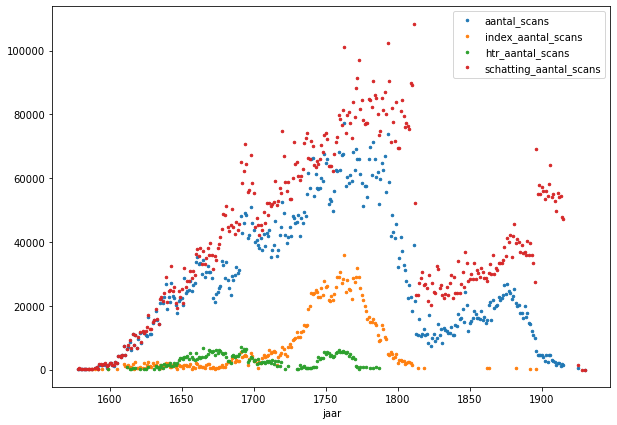

In [14]:
df_year_sum.index.name = "jaar"
df_year_sum.plot(figsize=(10, 7), linestyle="None", marker=".", markersize=5)

<AxesSubplot:xlabel='jaar'>

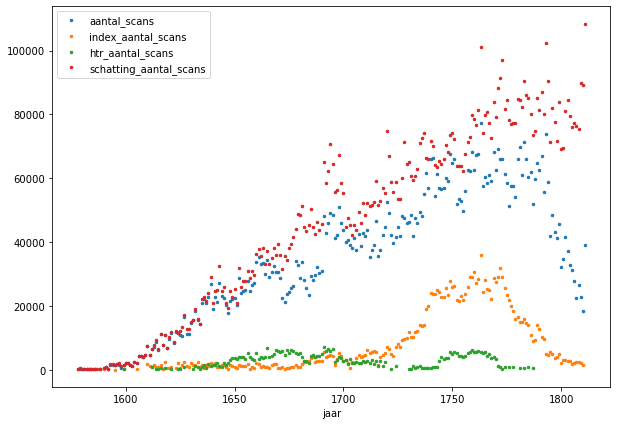

In [15]:
# Only <= 1811
df_year_sum[df_year_sum.index <= 1811].plot(
    figsize=(10, 7), linestyle="None", marker=".", markersize=5
)